<a href="https://colab.research.google.com/github/antonsysoev/Ass/blob/main/%D0%A1%D1%82%D0%B0%D1%82%D1%8C%D1%8F_%D0%B2_%D0%9F%D0%A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Пакет gridExtra не установлен. Графики будут отображены последовательно.
Оптимальные параметры светофоров:
  Перекресток Длительность_цикла Зеленый_сигнал Красный_сигнал Доля_зеленого
1           1           30.00000             21       9.000000         0.700
2           2           30.91189             20      10.911888         0.636
3           3           30.85280             22       8.852804         0.700
4           4           30.94508             22       8.945084         0.698

Минимальная достигнутая суммарная задержка: 5924.213 секунд


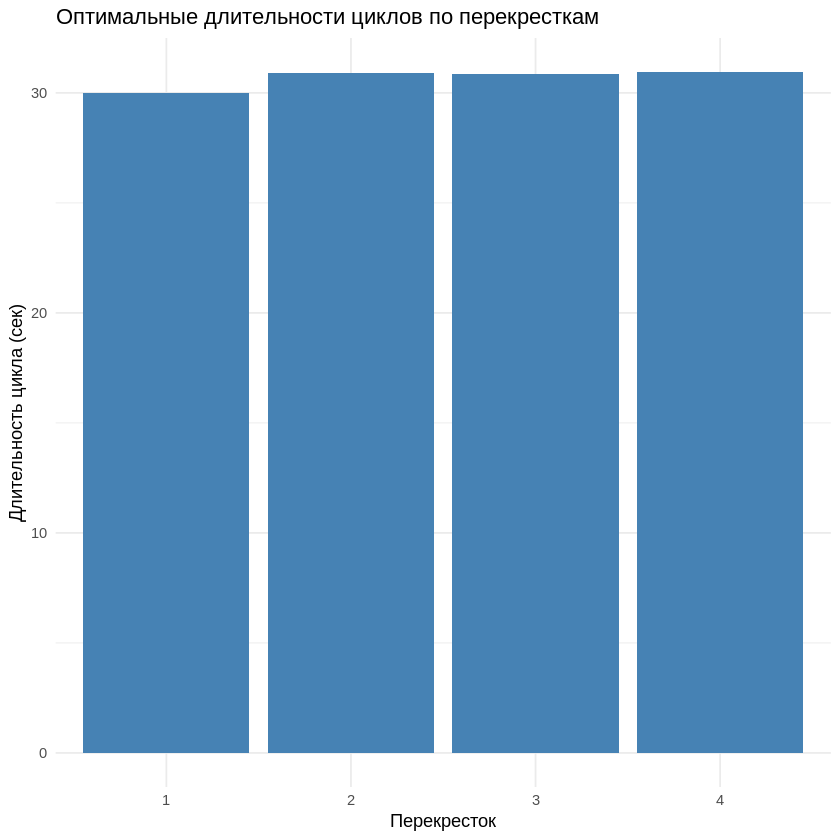

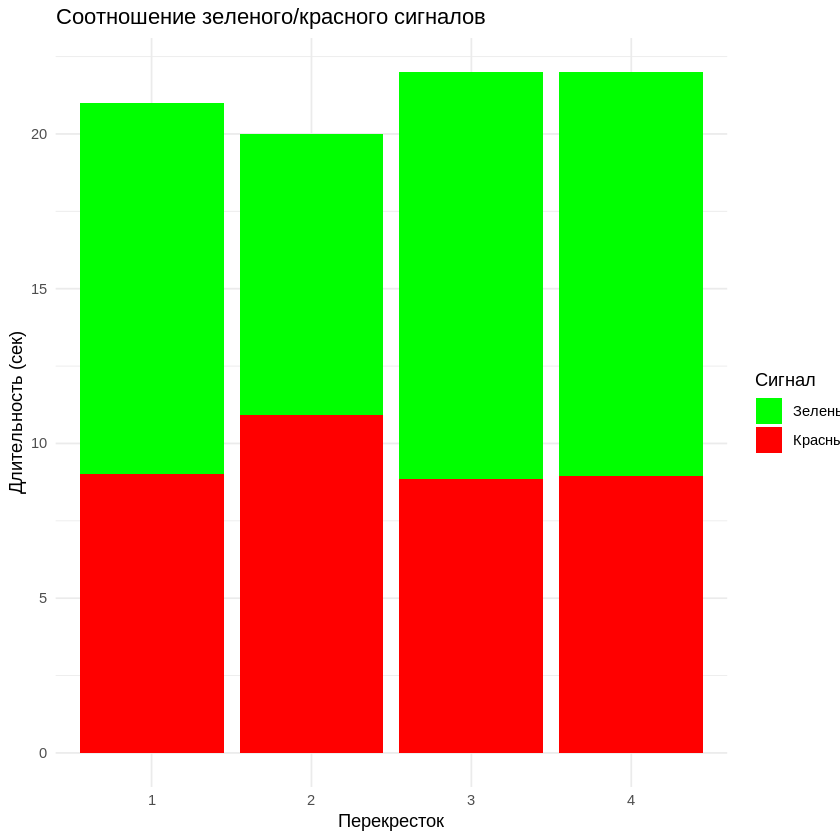

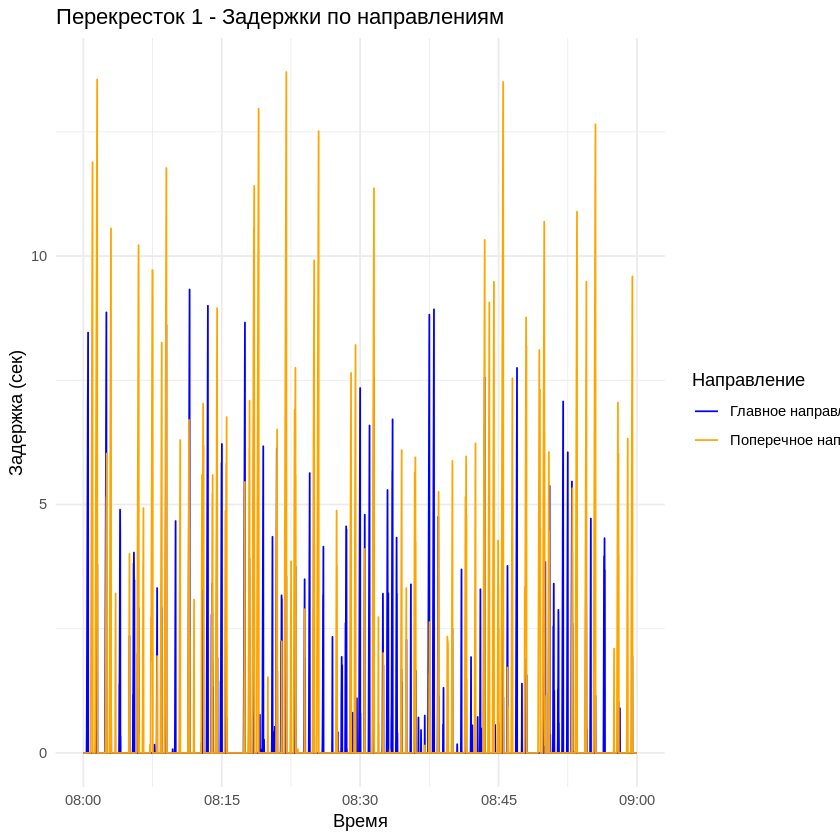

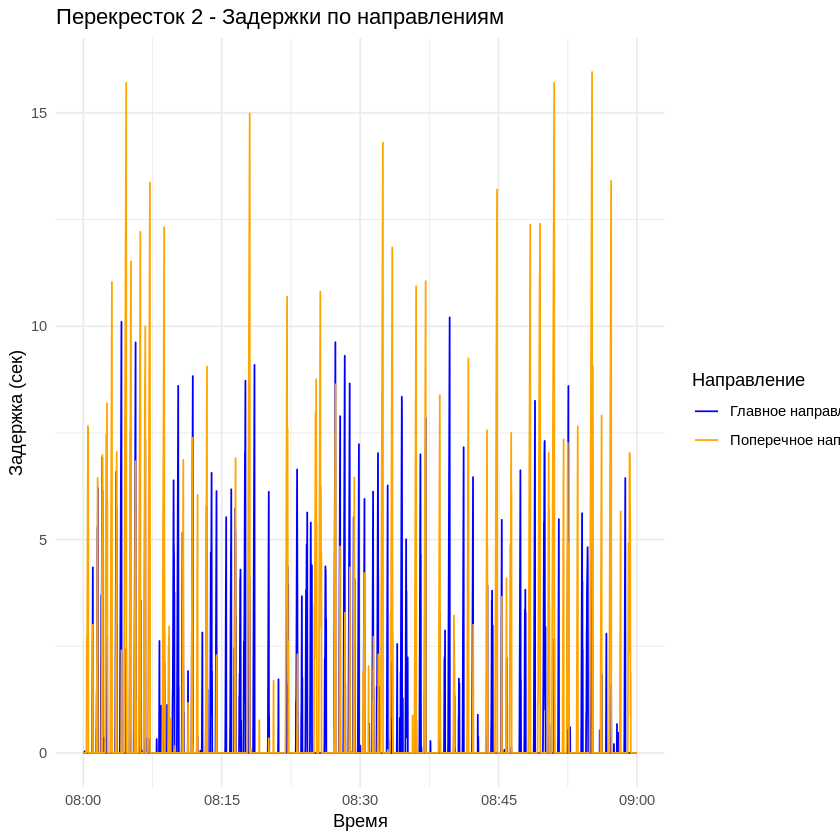

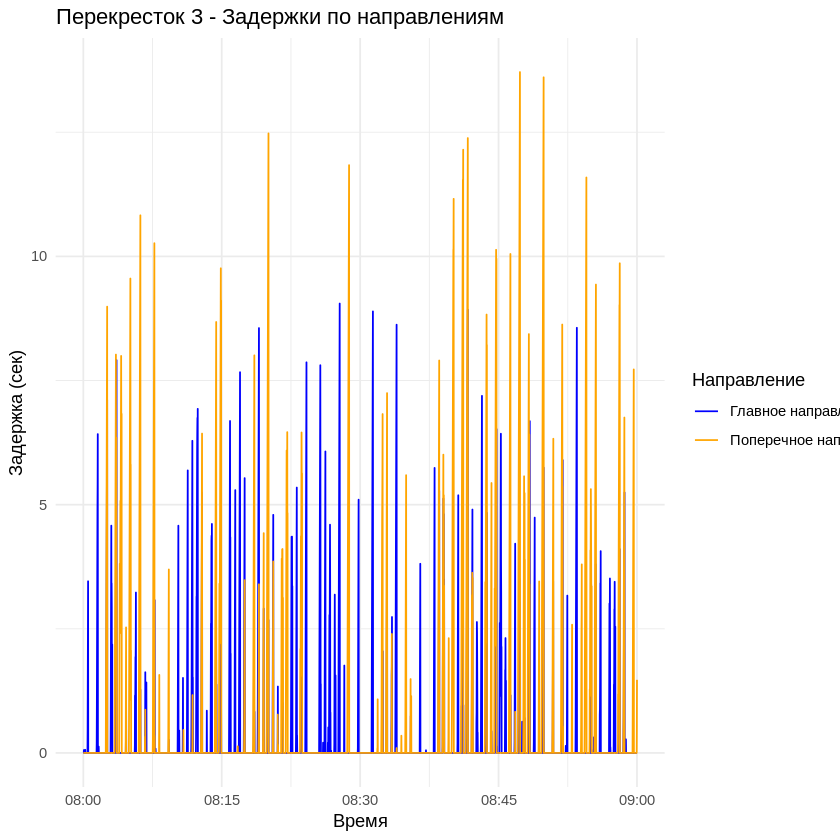

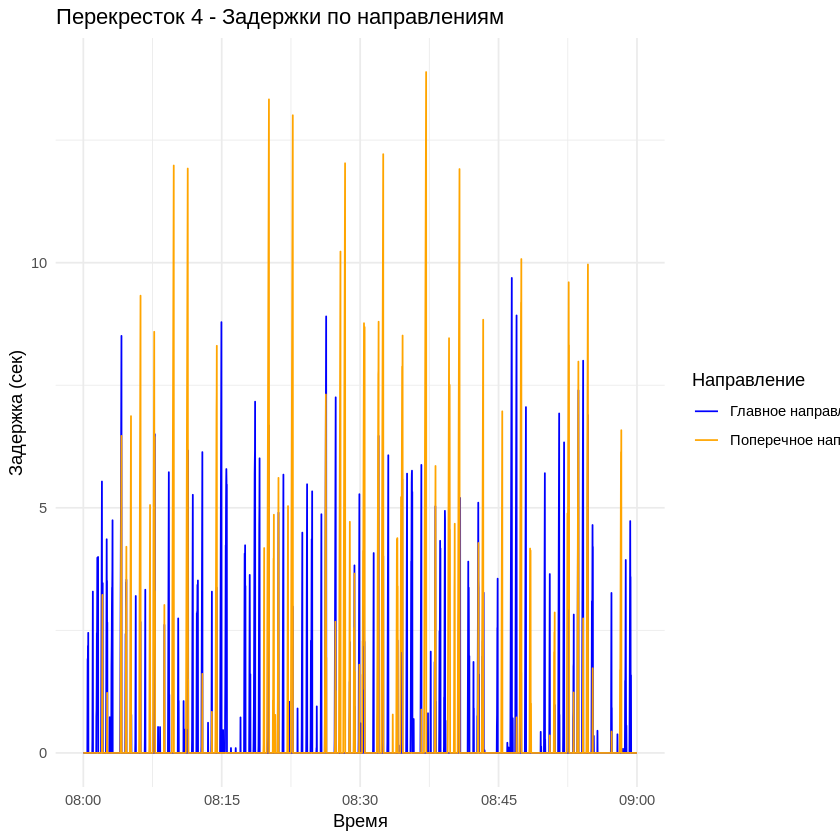

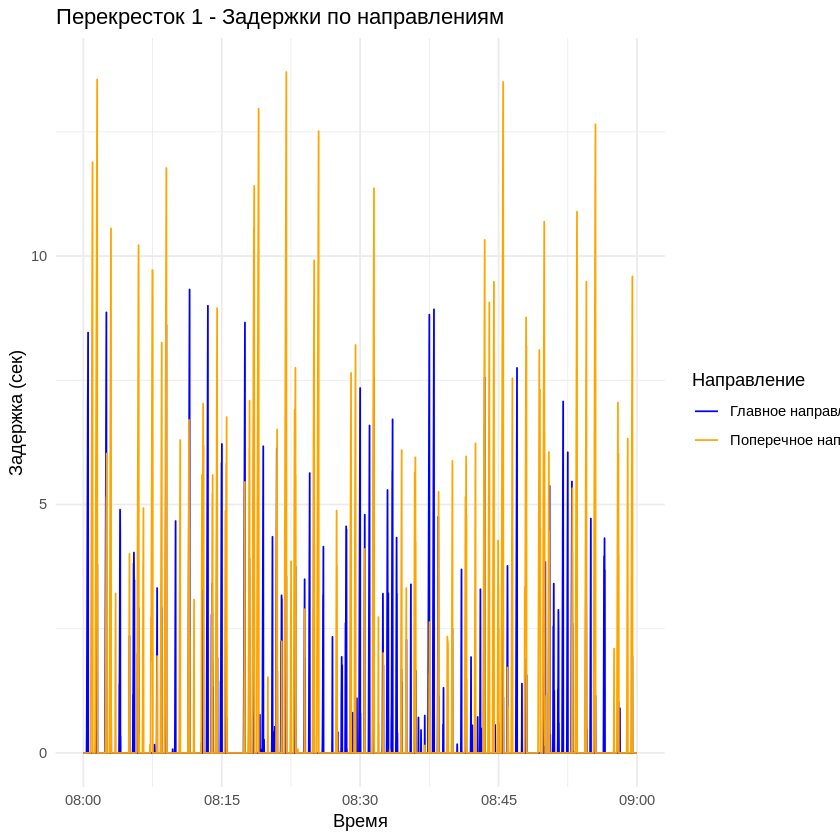

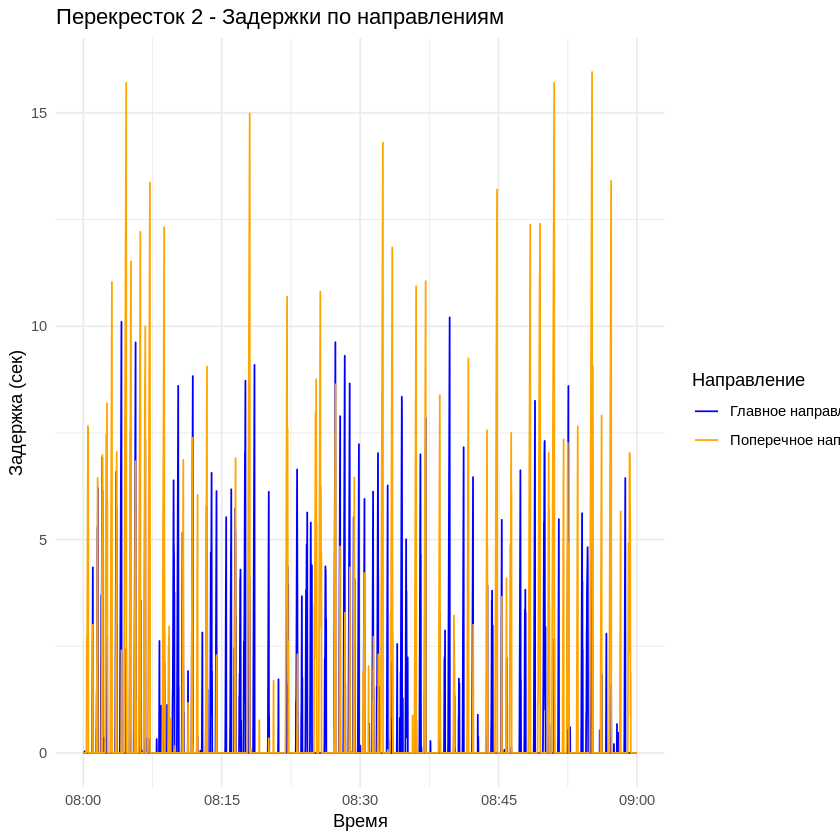

[[1]]

[[2]]

[[3]]

[[4]]


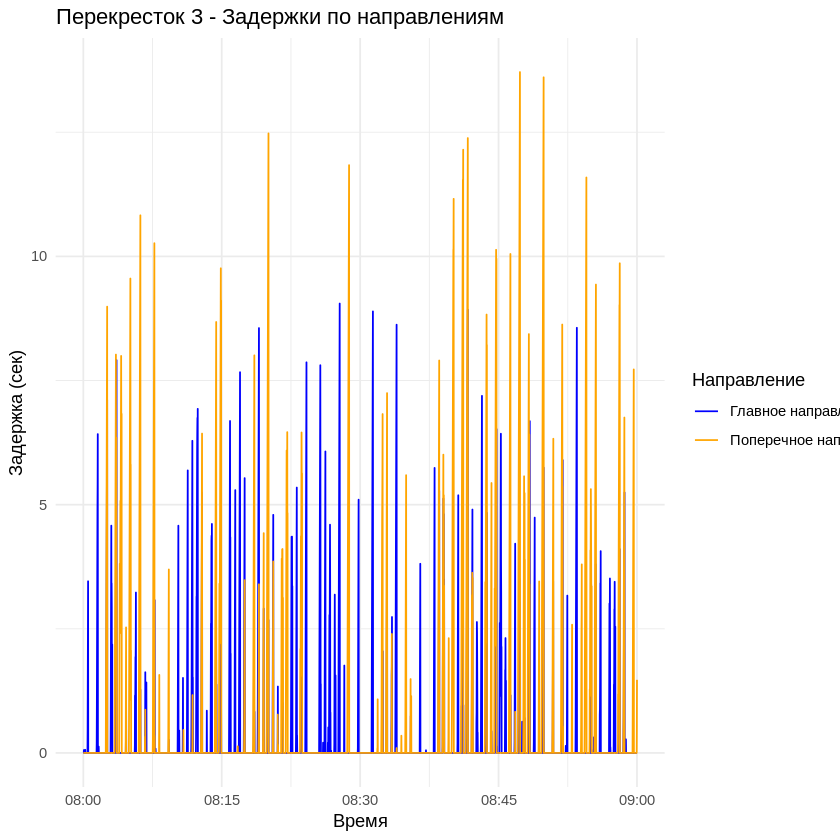

ERROR: Error: object 'results' not found


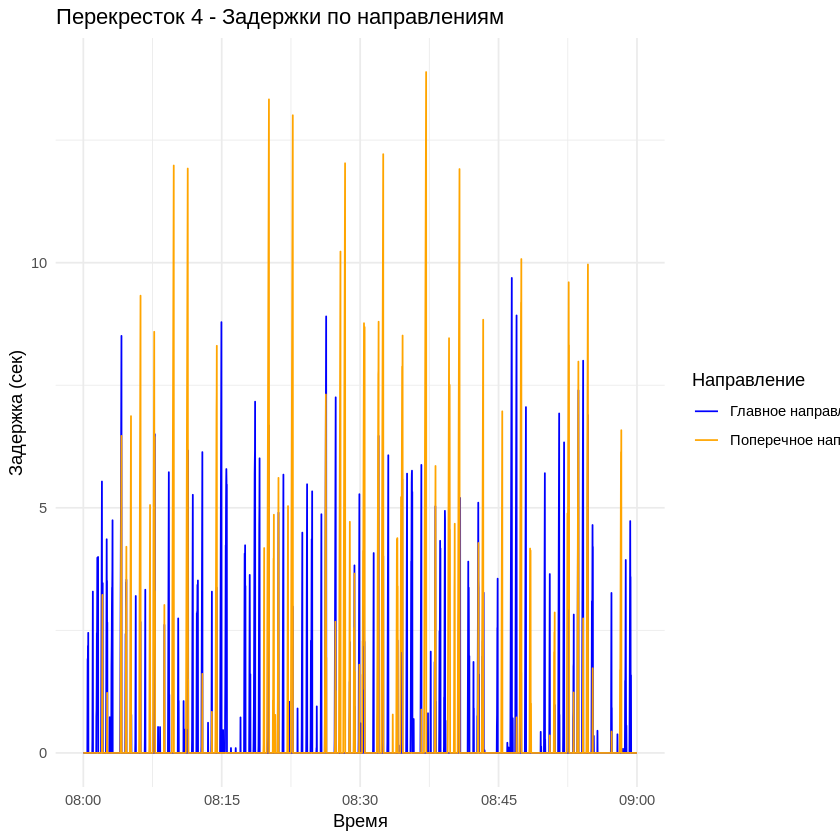

In [ ]:
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)

# Проверка и загрузка gridExtra
if (!requireNamespace("gridExtra", quietly = TRUE)) {
  cat("Пакет gridExtra не установлен. Графики будут отображены последовательно.\n")
  has_gridExtra <- FALSE
} else {
  library(gridExtra)
  has_gridExtra <- TRUE
}

# 1. Функция расчета задержки по модели HCM 2010
hcm_delay <- function(cycle_length, green_time, saturation_flow, arrival_rate, direction_priority = 1) {
  if (any(c(cycle_length, green_time, saturation_flow) <= 0) || is.na(arrival_rate)) {
    return(0)
  }

  adjusted_green <- green_time * direction_priority
  capacity <- (adjusted_green / cycle_length) * saturation_flow
  if (capacity <= 0) return(0)

  X <- arrival_rate / capacity
  X <- ifelse(X >= 1, 0.999, ifelse(X < 0, 0, X))

  d1 <- 0.5 * cycle_length * (1 - adjusted_green/cycle_length)^2 /
    (1 - min(X, 0.9) * adjusted_green/cycle_length)

  T <- 0.25
  k <- 0.5
  I <- 1.0
  d2 <- 900 * T * ((X - 1) + sqrt((X - 1)^2 + (8 * k * I * X)/(capacity * T)))
  d2 <- max(0, d2, na.rm = TRUE)

  total_delay <- d1 + d2
  return(max(0, total_delay, na.rm = TRUE))
}

# 2. Функция генерации данных о трафике
generate_traffic_dataset <- function(start_time, total_duration, lambda, n_intersections = 4) {
  start_time <- as.POSIXct(start_time)

  arrival_times <- c(0)
  while (tail(arrival_times, 1) < total_duration) {
    next_arrival <- tail(arrival_times, 1) + rexp(1, rate = lambda)
    if (next_arrival <= total_duration) {
      arrival_times <- c(arrival_times, next_arrival)
    } else {
      break
    }
  }

  if (length(arrival_times) > 1) arrival_times <- arrival_times[-1] else arrival_times <- numeric(0)

  if (length(arrival_times) > 0) {
    df <- data.frame(
      vehicle_id = 1:length(arrival_times),
      arrival_timestamp = start_time + arrival_times,
      arrival_seconds = arrival_times,
      intersection = sample(1:n_intersections, length(arrival_times), replace = TRUE),
      direction = sample(c("main", "cross"), length(arrival_times), replace = TRUE, prob = c(0.7, 0.3)),
      processing_time = pmax(1, rnorm(length(arrival_times), mean = 5, sd = 1)),
      hcm_delay = 0,
      actual_delay = 0,
      exit_time = NA,
      stringsAsFactors = FALSE
    )
  } else {
    df <- data.frame(
      vehicle_id = integer(),
      arrival_timestamp = as.POSIXct(character()),
      arrival_seconds = numeric(),
      intersection = integer(),
      direction = character(),
      processing_time = numeric(),
      hcm_delay = numeric(),
      actual_delay = numeric(),
      exit_time = numeric(),
      stringsAsFactors = FALSE
    )
  }
  return(df)
}

# 3. Основная функция моделирования
simulate_traffic <- function(traffic_data, start_time, total_duration,
                            green_durations, red_durations, capacity = 1100) {
  start_time <- as.POSIXct(start_time)
  n_intersections <- length(green_durations)

  queues_main <- lapply(1:n_intersections, function(x) integer())
  queues_cross <- lapply(1:n_intersections, function(x) integer())
  arrival_counts_main <- rep(0, n_intersections)
  arrival_counts_cross <- rep(0, n_intersections)

  time_stats <- data.frame(
    timestamp = rep(start_time + 0:total_duration, each = n_intersections),
    intersection = rep(1:n_intersections, total_duration + 1),
    time_seconds = rep(0:total_duration, each = n_intersections),
    queue_size_main = 0,
    queue_size_cross = 0,
    hcm_delay_main = 0,
    hcm_delay_cross = 0,
    actual_delay_main = 0,
    actual_delay_cross = 0,
    arrival_rate_main = 0,
    arrival_rate_cross = 0,
    stringsAsFactors = FALSE
  )

  for (t in 0:total_duration) {
    current_time <- start_time + t
    arrivals <- which(floor(traffic_data$arrival_seconds) == t)

    if (length(arrivals) > 0) {
      for (i in arrivals) {
        int <- traffic_data$intersection[i]
        if (traffic_data$direction[i] == "main") {
          queues_main[[int]] <- c(queues_main[[int]], i)
          arrival_counts_main[int] <- arrival_counts_main[int] + 1
        } else {
          queues_cross[[int]] <- c(queues_cross[[int]], i)
          arrival_counts_cross[int] <- arrival_counts_cross[int] + 1
        }
      }
    }

    for (int in 1:n_intersections) {
      idx <- which(time_stats$time_seconds == t & time_stats$intersection == int)
      cycle_length <- green_durations[int] + red_durations[int]
      cycle_pos <- t %% cycle_length
      is_green <- cycle_pos < green_durations[int]

      arrival_rate_main <- ifelse(t > 0, arrival_counts_main[int] / t * 3600, 0)
      arrival_rate_cross <- ifelse(t > 0, arrival_counts_cross[int] / t * 3600, 0)

      hcm_delay_main <- ifelse(is.finite(arrival_rate_main),
                             hcm_delay(cycle_length, green_durations[int], capacity,
                                      arrival_rate_main, 1), 0)
      hcm_delay_cross <- ifelse(is.finite(arrival_rate_cross),
                              hcm_delay(cycle_length, green_durations[int], capacity,
                                       arrival_rate_cross, 0.7), 0)

      current_actual_delay_main <- 0
      current_actual_delay_cross <- 0

      if (is_green) {
        if (length(queues_main[[int]]) > 0) {
          vehicle_idx <- queues_main[[int]][1]
          if (is.na(traffic_data$exit_time[vehicle_idx])) {
            exit_time <- t + traffic_data$processing_time[vehicle_idx]
            actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx])
            traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_main
            traffic_data$actual_delay[vehicle_idx] <- actual_delay
            traffic_data$exit_time[vehicle_idx] <- exit_time
            queues_main[[int]] <- queues_main[[int]][-1]
            current_actual_delay_main <- actual_delay
          }
        }

        if (length(queues_cross[[int]]) > 0 && t %% cycle_length < green_durations[int] - 5) {
          vehicle_idx <- queues_cross[[int]][1]
          if (is.na(traffic_data$exit_time[vehicle_idx])) {
            exit_time <- t + traffic_data$processing_time[vehicle_idx]
            actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx])
            traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_cross
            traffic_data$actual_delay[vehicle_idx] <- actual_delay
            traffic_data$exit_time[vehicle_idx] <- exit_time
            queues_cross[[int]] <- queues_cross[[int]][-1]
            current_actual_delay_cross <- actual_delay
          }
        }
      }

      if (length(queues_main[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues_main[[int]]])
        current_actual_delay_main <- mean(current_delays)
      }

      if (length(queues_cross[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues_cross[[int]]])
        current_actual_delay_cross <- mean(current_delays)
      }

      time_stats$queue_size_main[idx] <- length(queues_main[[int]])
      time_stats$queue_size_cross[idx] <- length(queues_cross[[int]])
      time_stats$hcm_delay_main[idx] <- hcm_delay_main
      time_stats$hcm_delay_cross[idx] <- hcm_delay_cross
      time_stats$actual_delay_main[idx] <- current_actual_delay_main
      time_stats$actual_delay_cross[idx] <- current_actual_delay_cross
      time_stats$arrival_rate_main[idx] <- arrival_rate_main
      time_stats$arrival_rate_cross[idx] <- arrival_rate_cross
    }
  }

  not_passed <- is.na(traffic_data$exit_time)
  traffic_data$actual_delay[not_passed] <- pmax(0, total_duration - traffic_data$arrival_seconds[not_passed])
  traffic_data$exit_time[not_passed] <- total_duration

  return(list(time_stats = time_stats,
             vehicle_stats = traffic_data,
             queues_main = queues_main,
             queues_cross = queues_cross))
}

# 4. Функция расчета суммарных задержек
calculate_total_delays <- function(green_times, red_times, traffic_data, total_duration, capacity = 1100) {
  if (length(green_times) != length(red_times)) {
    stop("Длительности зеленого и красного сигналов должны иметь одинаковую длину")
  }

  sim_result <- simulate_traffic(
    traffic_data = traffic_data,
    start_time = "2023-11-15 08:00:00",
    total_duration = total_duration,
    green_durations = green_times,
    red_durations = red_times,
    capacity = capacity
  )

  total_stats <- sim_result$vehicle_stats %>%
    group_by(intersection, direction) %>%
    summarise(
      total_hcm_delay = sum(hcm_delay, na.rm = TRUE),
      total_actual_delay = sum(actual_delay, na.rm = TRUE),
      avg_hcm_delay = mean(hcm_delay, na.rm = TRUE),
      avg_actual_delay = mean(actual_delay, na.rm = TRUE),
      .groups = 'drop'
    ) %>%
    mutate(
      green_time = green_times[intersection],
      red_time = red_times[intersection]
    )

  grand_total <- total_stats %>%
    summarise(
      total_hcm_delay = sum(total_hcm_delay),
      total_actual_delay = sum(total_actual_delay),
      avg_hcm_delay = mean(avg_hcm_delay),
      avg_actual_delay = mean(avg_actual_delay)
    )

  return(list(
    delay_stats = total_stats,
    grand_total = grand_total,
    simulation_result = sim_result
  ))
}

# 5. Функция оптимизации длительностей сигналов (обновленная)
optimize_signal_times <- function(traffic_data, total_duration,
                                min_cycle = 30, max_cycle = 90,
                                min_green_ratio = 0.3, max_green_ratio = 0.7,
                                n_intersections = 4, capacity = 900,
                                max_iter = 100, tol = 1) {

  # Целевая функция для оптимизации (теперь работает с полным циклом)
  objective_function <- function(params) {
    # Разделяем параметры на green_ratios и cycle_lengths
    green_ratios <- params[1:n_intersections]
    cycle_lengths <- params[(n_intersections+1):(2*n_intersections)]

    # Проверяем ограничения
    green_ratios <- pmax(pmin(green_ratios, max_green_ratio), min_green_ratio)
    cycle_lengths <- pmax(pmin(cycle_lengths, max_cycle), min_cycle)

    # Рассчитываем green_times и red_times
    green_times <- round(green_ratios * cycle_lengths)
    red_times <- cycle_lengths - green_times

    # Гарантируем минимальное время зеленого/красного
    green_times <- pmax(green_times, 5)
    red_times <- pmax(red_times, 5)

    # Рассчитываем задержки
    result <- calculate_total_delays(
      green_times = green_times,
      red_times = red_times,
      traffic_data = traffic_data,
      total_duration = total_duration,
      capacity = capacity
    )

    return(result$grand_total$total_actual_delay)
  }

  # Начальные значения
  initial_green_ratios <- rep((min_green_ratio + max_green_ratio)/2, n_intersections)
  initial_cycle_lengths <- rep((min_cycle + max_cycle)/2, n_intersections)
  initial_params <- c(initial_green_ratios, initial_cycle_lengths)

  # Границы параметров
  lower <- c(rep(min_green_ratio, n_intersections), rep(min_cycle, n_intersections))
  upper <- c(rep(max_green_ratio, n_intersections), rep(max_cycle, n_intersections))

  # Оптимизация
  optim_result <- optim(
    par = initial_params,
    fn = objective_function,
    method = "L-BFGS-B",
    lower = lower,
    upper = upper,
    control = list(maxit = max_iter, factr = tol)
  )

  # Извлекаем оптимальные параметры
  optimal_green_ratios <- optim_result$par[1:n_intersections]
  optimal_cycle_lengths <- optim_result$par[(n_intersections+1):(2*n_intersections)]

  optimal_green_times <- round(optimal_green_ratios * optimal_cycle_lengths)
  optimal_red_times <- optimal_cycle_lengths - optimal_green_times

  # Рассчитываем статистику для оптимальных значений
  optimal_stats <- calculate_total_delays(
    green_times = optimal_green_times,
    red_times = optimal_red_times,
    traffic_data = traffic_data,
    total_duration = total_duration,
    capacity = capacity
  )

  return(list(
    optimal_green_times = optimal_green_times,
    optimal_red_times = optimal_red_times,
    optimal_cycles = optimal_cycle_lengths,
    optimal_green_ratios = optimal_green_ratios,
    total_delay = optim_result$value,
    optim_result = optim_result,
    stats = optimal_stats
  ))
}

# 6. Пример использования с новой оптимизацией

# Генерация тестовых данных
set.seed(123)
start_time <- "2023-11-15 08:00:00"
traffic_data <- generate_traffic_dataset(
  start_time = start_time,
  total_duration = 3600,  # 1 час
  lambda = 0.8,
  n_intersections = 4
)

# Оптимизация сигналов (теперь для полного цикла)
optimization_result <- optimize_signal_times(
  traffic_data = traffic_data,
  total_duration = 3600,
  min_cycle = 30,    # минимальная длительность полного цикла
  max_cycle = 90,    # максимальная длительность полного цикла
  min_green_ratio = 0.3,  # минимальная доля зеленого
  max_green_ratio = 0.7,  # максимальная доля зеленого
  n_intersections = 4,
  max_iter = 50,
  tol = 10
)

# Вывод результатов оптимизации
cat("Оптимальные параметры светофоров:\n")
result_df <- data.frame(
  Перекресток = 1:4,
  Длительность_цикла = optimization_result$optimal_cycles,
  Зеленый_сигнал = optimization_result$optimal_green_times,
  Красный_сигнал = optimization_result$optimal_red_times,
  Доля_зеленого = round(optimization_result$optimal_green_ratios, 3)
)
print(result_df)

cat("\nМинимальная достигнутая суммарная задержка:", optimization_result$total_delay, "секунд\n")

# Визуализация результатов

# Сравнение длительностей циклов
plot_cycles <- ggplot(result_df, aes(x = factor(Перекресток), y = Длительность_цикла)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Оптимальные длительности циклов по перекресткам",
       x = "Перекресток", y = "Длительность цикла (сек)") +
  theme_minimal()

# Сравнение соотношений зеленого/красного
plot_ratios <- ggplot(result_df, aes(x = factor(Перекресток))) +
  geom_bar(aes(y = Зеленый_сигнал, fill = "Зеленый"), stat = "identity") +
  geom_bar(aes(y = Красный_сигнал, fill = "Красный"), stat = "identity",
           position = position_stack(reverse = TRUE)) +
  labs(title = "Соотношение зеленого/красного сигналов",
       x = "Перекресток", y = "Длительность (сек)", fill = "Сигнал") +
  scale_fill_manual(values = c("Зеленый" = "green", "Красный" = "red")) +
  theme_minimal()

# Вывод графиков
if (has_gridExtra) {
  grid.arrange(plot_cycles, plot_ratios, ncol = 1)
} else {
  print(plot_cycles)
  print(plot_ratios)
}

# Дополнительная визуализация задержек по направлениям
delay_plots <- lapply(1:4, function(i) {
  df <- optimization_result$stats$simulation_result$time_stats %>%
    filter(intersection == i)

  ggplot(df, aes(x = timestamp)) +
    geom_line(aes(y = actual_delay_main, color = "Главное направление")) +
    geom_line(aes(y = actual_delay_cross, color = "Поперечное направление")) +
    labs(title = paste("Перекресток", i, "- Задержки по направлениям"),
         x = "Время", y = "Задержка (сек)", color = "Направление") +
    theme_minimal() +
    scale_color_manual(values = c("Главное направление" = "blue", "Поперечное направление" = "orange"))
})

if (has_gridExtra) {
  grid.arrange(grobs = delay_plots, ncol = 2)
} else {
  lapply(delay_plots, print)
}


# Визуализация 1: Сравнение задержек по направлениям
plot_comparison_main <- ggplot(results$simulation_result$time_stats, aes(x = timestamp)) +
  geom_line(aes(y = hcm_delay_main, color = "Теоретическая (HCM)"), size = 0.8) +
  geom_line(aes(y = actual_delay_main, color = "Фактическая"), size = 0.8) +
  facet_wrap(~intersection, ncol = 2) +
  labs(title = "Задержки на главном направлении",
       x = "Время", y = "Задержка (сек)", color = "Тип задержки") +
  scale_color_manual(values = c("Теоретическая (HCM)" = "blue", "Фактическая" = "red")) +
  theme_minimal()

plot_comparison_cross <- ggplot(results$simulation_result$time_stats, aes(x = timestamp)) +
  geom_line(aes(y = hcm_delay_cross, color = "Теоретическая (HCM)"), size = 0.8) +
  geom_line(aes(y = actual_delay_cross, color = "Фактическая"), size = 0.8) +
  facet_wrap(~intersection, ncol = 2) +
  labs(title = "Задержки на поперечном направлении",
       x = "Время", y = "Задержка (сек)", color = "Тип задержки") +
  scale_color_manual(values = c("Теоретическая (HCM)" = "blue", "Фактическая" = "red")) +
  theme_minimal()

# Визуализация 2: Очереди на перекрестках
plot_queues <- ggplot(results$simulation_result$time_stats %>%
                     pivot_longer(cols = c(queue_size_main, queue_size_cross),
                                 names_to = "direction", values_to = "queue_size"),
                   aes(x = timestamp, y = queue_size, color = direction)) +
  geom_line(size = 0.8) +
  facet_wrap(~intersection, ncol = 2) +
  labs(title = "Размер очередей на перекрестках",
       x = "Время", y = "ТС в очереди", color = "Направление") +
  scale_color_manual(values = c("queue_size_main" = "darkgreen", "queue_size_cross" = "orange"),
                     labels = c("Главное", "Поперечное")) +
  theme_minimal()

# Визуализация 3: Суммарные задержки
plot_total_delays <- ggplot(results$delay_stats,
                          aes(x = factor(intersection), y = total_actual_delay, fill = direction)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Суммарные задержки по перекресткам",
       x = "Перекресток", y = "Суммарная задержка (сек)", fill = "Направление") +
  scale_fill_manual(values = c("main" = "blue", "cross" = "orange")) +
  theme_minimal()

# Визуализация 4: Средние задержки
plot_avg_delays <- ggplot(results$delay_stats,
                         aes(x = factor(intersection), y = avg_actual_delay, fill = direction)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Средние задержки по перекресткам",
       x = "Перекресток", y = "Средняя задержка (сек)", fill = "Направление") +
  scale_fill_manual(values = c("main" = "blue", "cross" = "orange")) +
  theme_minimal()

# Вывод всех графиков
if (has_gridExtra) {
  grid.arrange(
    plot_comparison_main,
    plot_comparison_cross,
    plot_queues,
    plot_total_delays,
    plot_avg_delays,
    ncol = 1,
    heights = c(1, 1, 1, 0.8, 0.8)
  )
} else {
  print(plot_comparison_main)
  print(plot_comparison_cross)
  print(plot_queues)
  print(plot_total_delays)
  print(plot_avg_delays)
}

# Вывод статистики
cat("Статистика по задержкам:\n")
print(results$delay_stats)

cat("\nОбщая статистика:\n")
print(results$grand_total)